# Práctico: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#This file contains information about music artists listened and tagged by the users.
artist_data = pd.read_csv("../data/lastfm/artists.dat", sep="\t")

#This file contains the set of tags available in the dataset (ojo con el enconding en este!)
user_tags = pd.read_csv("../data/lastfm/tags.dat", sep="\t", encoding='latin-1')

#This file contains the artists listened by each user.
#It also provides a listening count for each [user, artist] pair.
user_artists_plays = pd.read_csv("../data/lastfm/user_artists.dat", sep="\t")

#These files contain the tag assignments of artists provided by each particular user. 
#They also contain the timestamps when the tag assignments were done.
user_tag_artists = pd.read_csv("../data/lastfm/user_taggedartists.dat", sep="\t")
user_tag_artists_time = pd.read_csv("../data/lastfm/user_taggedartists-timestamps.dat", sep="\t")

#These files contain the friend relations between users in the database.
user_friends = pd.read_csv("../data/lastfm/user_friends.dat", sep="\t")

In [3]:
#artist_data.info()
user_tags.info()
#user_artist_plays.info()
#user_tag_artists.info()
#user_friends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tagID     11946 non-null  int64 
 1   tagValue  11946 non-null  object
dtypes: int64(1), object(1)
memory usage: 186.8+ KB


## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

#### Artistas más escuchados

Vamos a crear una variable nueva **user_count** que nos dice cuántos usuarios escucharon a cada artista.  
La variable **weight** se le asigna a cada artista y es la sumatoria de todas las escuchas de un conjunto de usuarios
para cada artista.  
Luego crearemos dos variables más a partir de las dos anteriores: **count_range** **weight_range**. Estas variables agrupan 
en 4 grupos cada una a cada artista en función de **user_ count** y **weight**, y nos permiten visualizar cómo se distribuye los diversos valores en el conjunto de información 


In [5]:
user_artists_plays['weight'].describe()

count     92834.00000
mean        745.24393
std        3751.32208
min           1.00000
25%         107.00000
50%         260.00000
75%         614.00000
max      352698.00000
Name: weight, dtype: float64

In [9]:
escuchas_artistas = user_artists_plays['artistID'].value_counts()
df_val_counts = pd.DataFrame(escuchas_artistas).sort_index().rename(columns={'artistID': 'value_counts'})
user_artist_plays_sorted = user_artists_plays.groupby(['artistID']).sum()
user_artist_plays_sorted['user_count'] = df_val_counts['value_counts']
user_artist_plays_sorted.reset_index(inplace=True)
#armamos un dataset con el feature nuevo user_count
df_user_artist_plays = user_artist_plays_sorted.drop(['userID'], axis=1)
#agregamos bins sobre el feature user_count
df_user_artist_plays['count_range'] = pd.cut(df_user_artist_plays['user_count'], [0,20, 50, 100,200,700])
df_user_artist_plays['weight_range'] = pd.cut(df_user_artist_plays['weight'], [0,20,50, 1000,10000,3000000])
df_user_artist_plays.head()


,artistID,weight,user_count,count_range,weight_range
0,1,771,3,"(0, 20]","(50, 1000]"
1,2,8012,12,"(0, 20]","(1000, 10000]"
2,3,775,3,"(0, 20]","(50, 1000]"
3,4,563,2,"(0, 20]","(50, 1000]"
4,5,913,2,"(0, 20]","(50, 1000]"


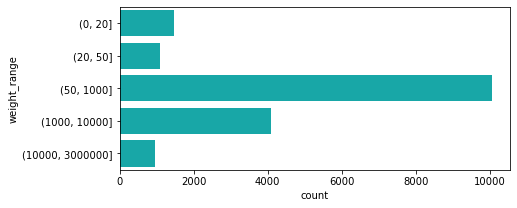

In [8]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='weight_range', data=df_user_artist_plays, color="c")

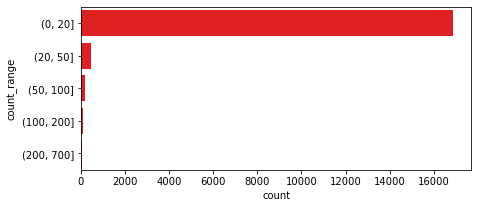

In [10]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='count_range', data=df_user_artist_plays, color="r")

Hay dos **datos interesantes** que obtenemos a partir de estos gráficos:  
a. la mayor masa de peso (**weitght_range**) asociado a artistas se concentra entre los 50 y los 1000 puntos;  
b. la mayor parte de los artistas (**count_range**) es escuchado por menos de 20 usuarios (de hecho, la mayoría solo es escuchado por 1 usuario);  

A continuación analizamos los artistas más escuchados utilizando dos variables: **weight** y **user_count**

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

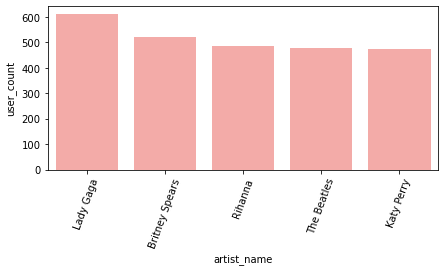

In [28]:
df_user_artist_plays['artist_name'] = artist_data['name']
most_play_artist_user= df_user_artist_plays.sort_values(by=['user_count'], ascending=False)

f, ax = plt.subplots(figsize=(7, 3))
sns.barplot(x="artist_name", y="user_count", data=most_play_artist_user.iloc[0:5, :],
            label="Total", color="r")
plt.xticks(rotation=70)

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

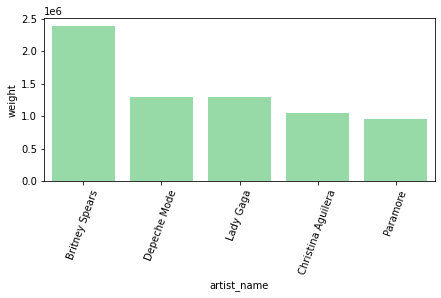

In [26]:
most_play_artist_weight= df_user_artist_plays.sort_values(by=['weight'], ascending=False)
f, ax = plt.subplots(figsize=(7, 3))
sns.set_color_codes('pastel')
sns.barplot(x="artist_name", y="weight", data=most_play_artist_weight.iloc[0:5, :],
            label="Total", color="g")
plt.xticks(rotation=70)

A partir de los últimos gráficos podemos decir que en este punto es determinante qué variable vamos a considerar para elegir a los artístas más escuchados, dado que, como vemos, aquellos que tienen mayor cantidad de usuarios no coinciden con aquellos que poseen más peso en las escuchas de usuarios en la global.

#### Distribución de cantidad de listens por usuarios

Filtramos el dataset con la información de cada usuario y la cantidad de listens (nos quedamos con las variables **userID** y **weight**). Lo que queremos ver es la distribución de la cantidad total de listens por usuarios en el dataset.

In [11]:
df_listens_per_users = user_artists_plays.drop(['artistID'], axis=1)
df_listens_per_users = df_listens_per_users.groupby(['userID']).sum().reset_index()
df_listens_per_users.sort_values(by=['weight'], ascending=False).head()

,userID,weight
705,757,480039
1802,2000,468409
1280,1418,416349
1482,1642,388251
1002,1094,379125


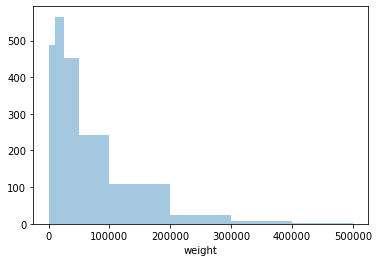

In [11]:
bins_list = [0, 10000, 25000, 50000, 100000, 200000, 300000, 400000, 500000]
sns.distplot(df_listens_per_users['weight'], bins=bins_list, kde=False)

El gráfico muestra que claramente la mayor parte de la masa de instancias de listens se congrega en entre en el intervalo que va de 0 a 25000. Esto lo podemos analizar con los siguientes estadísticos.

In [12]:
df_listens_per_users['weight'].describe()

count      1892.000000
mean      36566.582981
std       48744.552394
min           3.000000
25%        9742.250000
50%       21573.000000
75%       42963.750000
max      480039.000000
Name: weight, dtype: float64

Si bien el 75% de las instancias se encuentran debajo de los 43000 listens, aun así el promedio se ubica en 36000. Esto se debe a la cantidad de listens que aglomeran el 25% de las intancias con los valores más altos, algo que no debemos ignorar. Si fueran outliers podríamos simplemente limpiarlos o procesarlos de alguna forma, pero cabe preguntarse si ese mismo tratamiento puede realizarse sin más en este dataset.

#### Géneros musicales más escuchados

¿Podemos obtener de la información en los datasets los géneros más escuchados? Poseemos un conjunto de datos donde los usuarios han etiquetado los estilos asociados a cada artista (**user_tag_artists**). Asumimos que han escuchado a estos artistas.  
La pregunta es ¿cómo usamos estas etiquetas? Hay dos posibilidades: o bien realizamos un conteo de aquellas etiquetas que aparecen más (esto sería asumir una relación lineal entre cantidad de tags igual a cantidad de escuchas) o podríamos hacer un esfuerzo en cruzar los tags más comúnes con los artistas más escuchados. La idea es que si encontramos cómo se distribuyen lso géneros en los artistas con mayor masa de escuchas, tenemos una buena idea de cuáles son los géneros más escuchados.  
Asignamos a una nueva variable **df_tags** el dataset **user_tag_artists** con la variable agregada **tagValue** para saber cuál es el estilo en cuestión. Luego asignamos a la variable  **df_tags_counts** un dataset con el conteo de tags.

In [30]:
df_tags = pd.merge(user_tag_artists, user_tags, how='left', on=['tagID', 'tagID'])
df_tags.head()

,userID,artistID,tagID,day,month,year,tagValue
0,2,52,13,1,4,2009,chillout
1,2,52,15,1,4,2009,downtempo
2,2,52,18,1,4,2009,electronic
3,2,52,21,1,4,2009,trip-hop
4,2,52,41,1,4,2009,female vovalists


In [29]:
tag_counts = user_tag_artists['tagID'].value_counts()
df_tags_counts = pd.DataFrame(tag_counts).sort_index().rename(columns={'tagID': 'tag_counts'})
df_tags_counts = df_tags_counts.reset_index().rename(columns={'index': 'tagID'})
df_tags_counts = pd.merge(df_tags_counts, user_tags,how='left', on=['tagID', 'tagID'] ).sort_values(by=['tag_counts'], ascending=False) 
df_tags_counts.head()

,tagID,tag_counts,tagValue
71,73,7503,rock
23,24,5418,pop
77,79,5251,alternative
17,18,4672,electronic
79,81,4458,indie


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

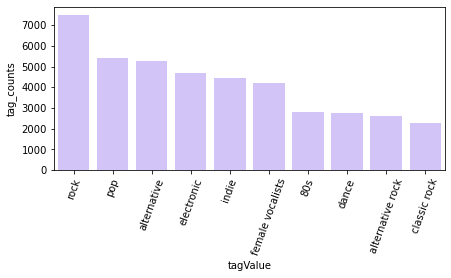

In [23]:
f, ax = plt.subplots(figsize=(7, 3))
sns.set_color_codes('pastel')
sns.barplot(x="tagValue", y="tag_counts", data=df_tags_counts.iloc[0:10, :],
            label="Total", color="m")
plt.xticks(rotation=70)

En el gráfico podemos observar los 10 tags de géneros musicales más utilizados o "marcados" por usuarios.  
¿Es esto realmente representativo de los géneros más escuchados?
Podría ser el caso que un solo usuario hubiera tageado a una gran cantidad de artistas con un género de manera deliberada y malintencionada.  
Supongamos que 100 usuarios se hubieran puesto en campaña de taggear a todo lo que se les cruzara como "alternative". Le tomaría etiquetar a 100 artistas distintos cada uno para generar una muestra de 10000 tags! Este sería un escenario en el que menos del 7% de los usuarios que tagearan a menos de 7% de los artistas lograrían sesgar nuestra percepción acerca del género más escuchado.